In [1]:
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive
from operator import itemgetter
from datetime import datetime

#TODO: Remove this and just have separate batch_animal_count_inference.py
from collections import OrderedDict

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = Image.open(file_path)
    return transform(image)

def remove_images_with_no_datetime(images):
    new_images = []
    for image in images:
        if("datetime" in image):
            new_images.append(image)
    return new_images

def get_sorted_images(coco_key):
    images = coco_key["images"]
    images = remove_images_with_no_datetime(images)
    return sorted(images, key=itemgetter("datetime"))

def flatten_list(data):
    return [image for batch in data for image in batch]

def get_data_sets(downloaded_data_dir, json_file_name):
    json_file = open(downloaded_data_dir + json_file_name)
    coco_key = json.load(json_file)
    images = get_sorted_images(coco_key)

    batch_data, batch_labels, data, labels = [], [], [], []
    previous_time_stamp = None
    for index, image in enumerate(images):
        time_stamp = datetime.strptime(image["datetime"], '%Y:%m:%d %H:%M:%S')
        file_name = image["file_name"]
        file_path = downloaded_data_dir + file_name

        if os.path.isfile(file_path):
            label = coco_key["annotations"][index]["category_id"]
            image_tensor = None
            try:
                image_tensor = get_image_tensor(file_path)
            except:
                print("Truncated image encountered, leaving out of training and testing")
                continue

            if index == 0 or (time_stamp - previous_time_stamp).total_seconds() < 60:
                batch_data.append(image_tensor)
                batch_labels.append(label)
            else:
                data.append(torch.stack(batch_data))
                labels.append(torch.FloatTensor(batch_labels))

                batch_data, batch_labels = [], []
                batch_data.append(image_tensor)
                batch_labels.append(label)

            previous_time_stamp = time_stamp


    batch_training_data, batch_testing_data, batch_training_labels, batch_testing_labels = train_test_split(data, labels, test_size = 0.20)
    training_data = flatten_list(batch_training_data)
    testing_data = flatten_list(batch_testing_data)
    training_labels = flatten_list(batch_training_labels)
    testing_labels = flatten_list(batch_testing_labels)

    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    print("Number of batches for testing: " + str(len(batch_testing_data)))

    json_file.close()

    return training_data, testing_data, training_labels, testing_labels, batch_testing_data, batch_testing_labels

In [4]:
def print_image(image_tensor, prediction, downloaded_data_dir, index):
    image_file_name = downloaded_data_dir + str(prediction.item()) + "_" + str(index) + ".png"

    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + str(prediction.item()) + " Animals Present")
    plt.show()
    #plt.imsave(image_file_name, image_tensor[0].cpu(), cmap="gray")

def print_testing_analysis(all_labels, all_predictions, title, downloaded_data_dir):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cf_matrix = np.flip(cf_matrix, axis=0)
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    subplot.yaxis.set_ticklabels([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

    plot_file_name = downloaded_data_dir + title + "_Confusion_Matrix.png"
    #plt.savefig(plot_file_name)
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for batch in training_loader:
        data, labels = batch['data'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        output = model(data).flatten()

        loss = criterion(output, labels)
        running_loss += loss.item()
        num_correct += (output.round() == labels).sum().item()
        loss.backward()
        optimizer.step()

    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images, downloaded_data_dir):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, batch in enumerate(testing_loader):
        data, labels = batch['data'].to(device), batch['label'].to(device)
        output = model(data).flatten()

        loss = criterion(output, labels)
        running_loss += loss.item()
        for index, prediction in enumerate(output.round()):
            all_predictions.append(prediction.cpu().item())
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction, downloaded_data_dir, i)

        all_labels.extend(labels.cpu())

    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

def test_batch(model, batch_testing_loader, criterion, print_incorrect_images, downloaded_data_dir):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for batch in batch_testing_loader:
        data, labels = torch.squeeze(batch['data'], dim=0).to(device), batch['label'].to(device)

        # This is to prevent cuda memory issues for large batches
        max_prediction = 0
        for image in data:
            image = torch.unsqueeze(image, dim=0)
            output = model(image).flatten()
            max_prediction = max(max_prediction, output.round().item())

        max_prediction = torch.tensor(max_prediction).to(device)
        max_label = torch.max(labels)

        loss = criterion(max_prediction, max_label)
        running_loss += loss.item()

        if max_prediction == max_label:
            num_correct += 1

        all_predictions.append(max_prediction.cpu())
        all_labels.append(max_label.cpu())

    loss = running_loss/len(batch_testing_data_set)
    accuracy = num_correct/len(batch_testing_data_set)
    return loss, accuracy, all_labels, all_predictions

In [5]:
def train_and_test(num_epochs, model, model_name, training_loader, testing_loader, batch_testing_loader, device, criterion, downloaded_data_dir):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    highest_batch_testing_accuracy = 0.0

    for epoch in range(num_epochs):
        print("Epoch: " + str(epoch))

        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))

        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False, downloaded_data_dir)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

        batch_testing_loss, batch_testing_accuracy, batch_labels, batch_predictions = test_batch(model, batch_testing_loader, criterion, False, downloaded_data_dir)
        print("batch testing loss: " + str(batch_testing_loss) + " and batch testing accuracy: " + str(batch_testing_accuracy))

        if highest_batch_testing_accuracy < batch_testing_accuracy:
            print("Highest batch testing accuracy achieved, saving weights")
            highest_batch_testing_accuracy = batch_testing_accuracy
            torch.save(model, "saved_models/batch_count_" + model_name + ".pt")
            print_testing_analysis(batch_labels, batch_predictions, model_name, downloaded_data_dir)

# Declaring Constants

In [19]:
num_epochs = 5
num_classes = 10
batch_size = 10
json_file_name = "animal_count_key.json"
downloaded_data_dir = "animal_count_manually_labeled_wildlife_data/"

print(torch.__version__)
print(torchvision.__version__)
print("torch.cuda.is_available(): " + str(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
criterion = nn.MSELoss()

2.0.1+cu118
0.15.2+cu118
torch.cuda.is_available(): True


# Loading Data

In [7]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/animal_count_manually_labeled_wildlife_data

Mounted at /content/drive


In [8]:
training_data, testing_data, training_labels, testing_labels, batch_testing_data, batch_testing_labels = get_data_sets(downloaded_data_dir, json_file_name)
training_data_set = image_data_set(training_data, training_labels)
testing_data_set = image_data_set(testing_data, testing_labels)
batch_testing_data_set = image_data_set(batch_testing_data, batch_testing_labels)
training_loader = DataLoader(dataset = training_data_set, batch_size = batch_size, shuffle = True)
testing_loader = DataLoader(dataset = testing_data_set, batch_size = batch_size, shuffle = True)
batch_testing_loader = DataLoader(dataset = batch_testing_data_set, batch_size = 1, shuffle = True)


Number of training photos: 2972
Number of testing photos: 997
Number of batches for testing: 155


# Declaring Models

In [20]:
resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, 1)

resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
in_features = resnet152.fc.in_features
resnet152.fc = nn.Linear(in_features, 1)

vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.DEFAULT)
in_features = vit_l_16.heads[0].in_features
vit_l_16.heads[0] = nn.Linear(in_features, 1)

if torch.cuda.device_count() > 1:
    print("Multiple GPUs available, using: " + str(torch.cuda.device_count()))
    resnet50 = nn.DataParallel(resnet50)
    resnet152 = nn.DataParallel(resnet152)
    vit_l_16 = nn.DataParallel(vit_l_16)

# Training


Training and Testing ResNet50
Epoch: 0
training loss: 0.03774011438266872 and training accuracy: 0.8065275908479138
testing loss: 0.052687898722879864 and testing accuracy: 0.7873620862587764
batch testing loss: 0.7677419354838709 and batch testing accuracy: 0.7677419354838709
Highest batch testing accuracy achieved, saving weights


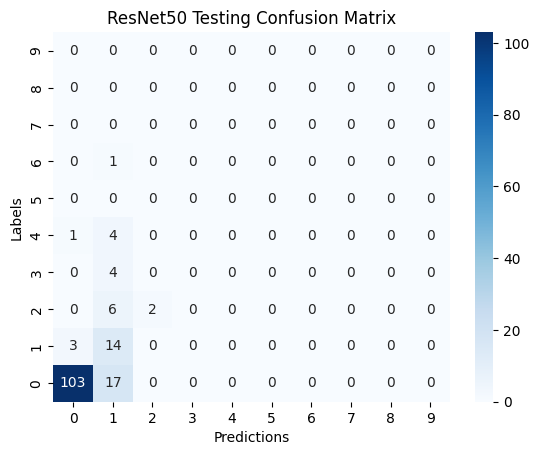

ResNet50 Accuracy: 0.7677419354838709
ResNet50 Precision: 0.8302447208714003
ResNet50 Recall: 0.7677419354838709
ResNet50 F-Score: 0.7719627998042095
Epoch: 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.032357157899623346 and training accuracy: 0.8159488559892328
testing loss: 0.038199617769363654 and testing accuracy: 0.7452357071213641
batch testing loss: 0.6 and batch testing accuracy: 0.7483870967741936
Epoch: 2
training loss: 0.025288269934285193 and training accuracy: 0.8623822341857336
testing loss: 0.04175203345826226 and testing accuracy: 0.7733199598796389
batch testing loss: 0.44516129032258067 and batch testing accuracy: 0.8258064516129032
Highest batch testing accuracy achieved, saving weights


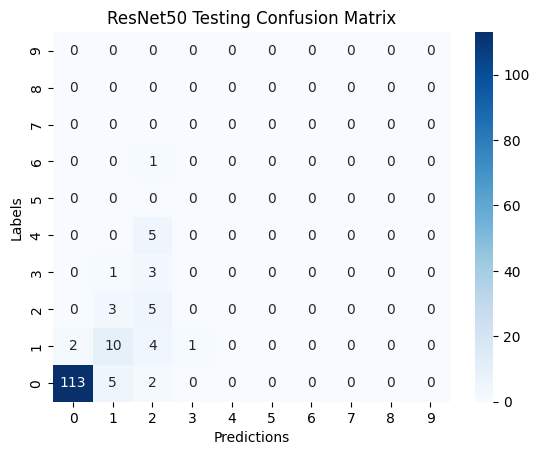

ResNet50 Accuracy: 0.8258064516129032
ResNet50 Precision: 0.8313574961246033
ResNet50 Recall: 0.8258064516129032
ResNet50 F-Score: 0.8239086620692662
Epoch: 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.019745895305640925 and training accuracy: 0.8855989232839838
testing loss: 0.0688842542361143 and testing accuracy: 0.7662988966900702
batch testing loss: 0.567741935483871 and batch testing accuracy: 0.8064516129032258
Epoch: 4
training loss: 0.02076180298025513 and training accuracy: 0.879878869448183
testing loss: 0.03762939676115572 and testing accuracy: 0.8164493480441324
batch testing loss: 0.5161290322580645 and batch testing accuracy: 0.8387096774193549
Highest batch testing accuracy achieved, saving weights


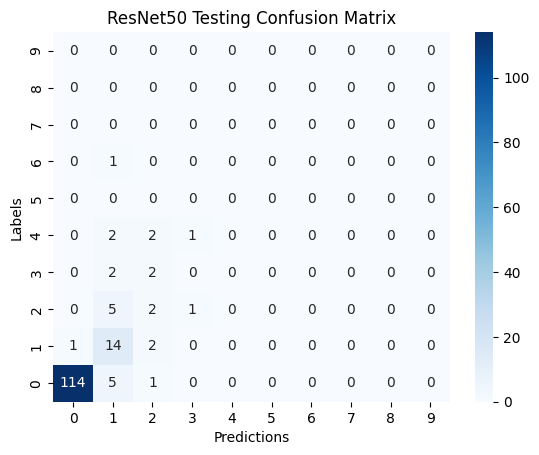

ResNet50 Accuracy: 0.8387096774193549
ResNet50 Precision: 0.8318786843137572
ResNet50 Recall: 0.8387096774193549
ResNet50 F-Score: 0.8300368447937201


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print("\nTraining and Testing ResNet50")
train_and_test(num_epochs, resnet50, "ResNet50", training_loader, testing_loader, batch_testing_loader, device, criterion, downloaded_data_dir)


Training and Testing ResNet152
Epoch: 0
training loss: 0.04945573672711157 and training accuracy: 0.7664872139973082
testing loss: 0.6073786013104852 and testing accuracy: 0.1464393179538616
batch testing loss: 9.64516129032258 and batch testing accuracy: 0.07741935483870968
Highest batch testing accuracy achieved, saving weights


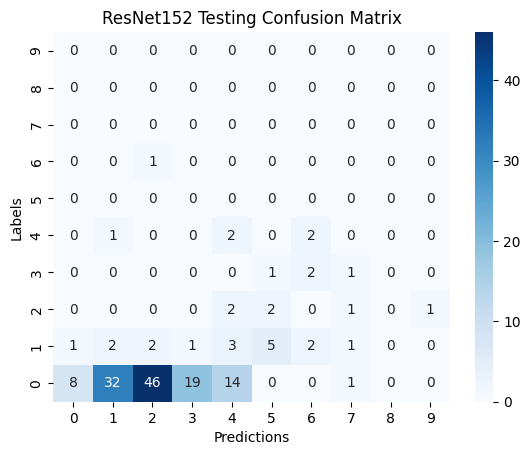

ResNet152 Accuracy: 0.07741935483870968
ResNet152 Precision: 0.6975115207373271
ResNet152 Recall: 0.07741935483870968
ResNet152 F-Score: 0.10942350972358475
Epoch: 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.03727674639744942 and training accuracy: 0.8152759084791387
testing loss: 0.2964696159124853 and testing accuracy: 0.41624874623871616
batch testing loss: 2.4387096774193546 and batch testing accuracy: 0.4
Highest batch testing accuracy achieved, saving weights


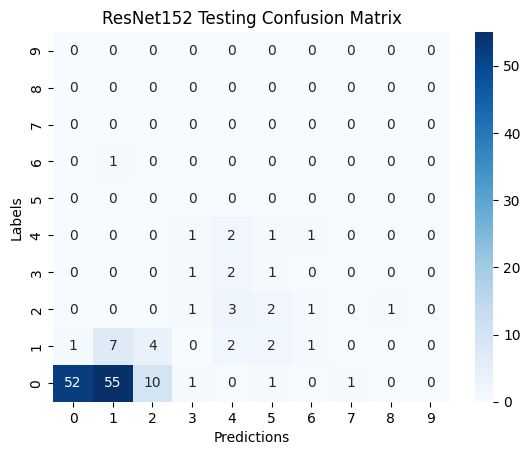

ResNet152 Accuracy: 0.4
ResNet152 Precision: 0.785392574558734
ResNet152 Recall: 0.4
ResNet152 F-Score: 0.5002729016275539
Epoch: 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.03433325822956479 and training accuracy: 0.8142664872139973
testing loss: 0.12830248167560834 and testing accuracy: 0.7221664994984955
batch testing loss: 0.864516129032258 and batch testing accuracy: 0.7677419354838709
Highest batch testing accuracy achieved, saving weights


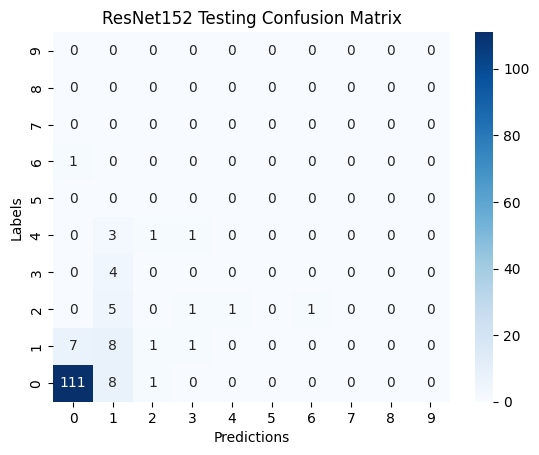

ResNet152 Accuracy: 0.7677419354838709
ResNet152 Precision: 0.7534833288153971
ResNet152 Recall: 0.7677419354838709
ResNet152 F-Score: 0.7581218038121803
Epoch: 3
training loss: 0.02688945634171497 and training accuracy: 0.8408479138627187
testing loss: 0.04656369357305386 and testing accuracy: 0.7612838515546639
batch testing loss: 0.4645161290322581 and batch testing accuracy: 0.8580645161290322
Highest batch testing accuracy achieved, saving weights


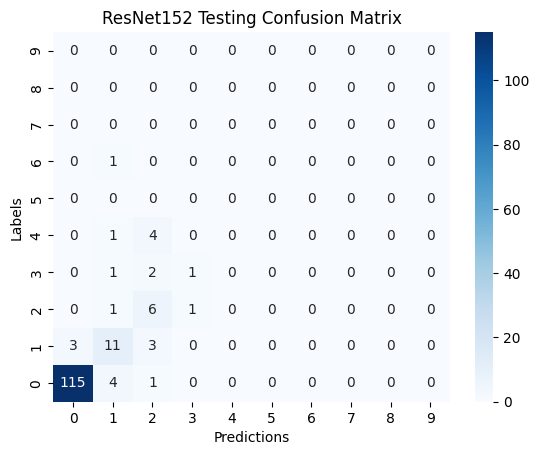

ResNet152 Accuracy: 0.8580645161290322
ResNet152 Precision: 0.8502661793905211
ResNet152 Recall: 0.8580645161290322
ResNet152 F-Score: 0.8496039275925423
Epoch: 4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.021960344260670044 and training accuracy: 0.8707940780619112
testing loss: 0.12786465214608367 and testing accuracy: 0.7482447342026078
batch testing loss: 0.5935483870967742 and batch testing accuracy: 0.832258064516129


In [22]:
print("\nTraining and Testing ResNet152")
train_and_test(num_epochs, resnet152, "ResNet152", training_loader, testing_loader, batch_testing_loader, device, criterion, downloaded_data_dir)

#TODO: Remove and just have batch_animal_count_inference.py



In [27]:
def get_image_tensor(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform(image)

def get_image_dictionary(directory):
    image_dictionary = {}
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isdir(file_path):
            leaf_image_dictionary = get_image_dictionary(file_path)
            image_dictionary.update(leaf_image_dictionary)
        elif os.path.isfile(file_path):
            try:
                image = Image.open(file_path)
                datetime = image._getexif()[36867]
                image_tensor = get_image_tensor(image)
                image_dictionary[datetime] = image_tensor
            except:
                print("Truncated image encountered, leaving out of training and testing")
                continue

    image_dictionary = OrderedDict(sorted(image_dictionary.items()))
    return image_dictionary

def get_batched_images(dictionary):
    images, batch_images = [], []
    previous_time_stamp = None
    for key, value in dictionary.items():
        time_stamp = datetime.strptime(key, '%Y:%m:%d %H:%M:%S')
        if previous_time_stamp == None or (time_stamp - previous_time_stamp).total_seconds() < 60:
            batch_images.append(value)
        else:
            images.append(torch.stack(batch_images))
            batch_images = []
            batch_images.append(value)

        previous_time_stamp = time_stamp

    return images

def get_max_predictions(batched_images, model, device):
    max_predictions = []
    for image_batch in batched_images:
        # This is to prevent cuda memory issues for large batches
        max_prediction = 0
        for image in image_batch:
            image = torch.unsqueeze(image, dim=0).to(device)
            output = model(image).flatten()
            max_prediction = max(max_prediction, output.round().item())
        max_predictions.append(max_prediction)
    return max_predictions

def analyze(directory, model, device):
    image_dictionary = get_image_dictionary(directory)
    print("len(image_dictionary):", len(image_dictionary))

    batched_images = get_batched_images(image_dictionary)
    print("len(batched_images):", len(batched_images))

    max_predictions = get_max_predictions(batched_images, model, device)
    print("len(max_predictions):", len(max_predictions))

    predicted_total_num_animals = sum(max_predictions)
    print("predicted_total_num_animals:", predicted_total_num_animals)
    print("max_predictions:", max_predictions)

In [24]:
cottonwood_directory = "Cottonwood_Eastface_6.06_6.13/"
ngilchrist_directory = "NGilchrist_Eastface_6.06_6.13/"
sgilchrist_directory = "SGilchrist_Eastface_6.06_6.13/"

print(torch.__version__)
print(torchvision.__version__)
print("torch.cuda.is_available(): " + str(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

2.0.1+cu118
0.15.2+cu118
torch.cuda.is_available(): True


In [25]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/SGilchrist_Eastface_6.06_6.13
!unzip -qq drive/MyDrive/Cottonwood_Eastface_6.06_6.13
!unzip -qq drive/MyDrive/NGilchrist_Eastface_6.06_6.13

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
print("Analyzing Cottonwood")
analyze(cottonwood_directory, resnet152, device)

print("\nAnalyzing NGilchrist")
analyze(ngilchrist_directory, resnet152, device)

print("\nAnalyzing SGilchrist")
analyze(sgilchrist_directory, resnet152, device)

Analyzing Cottonwood
len(image_dictionary): 40
len(batched_images): 5
len(max_predictions): 5
predicted_total_num_animals: 1.0
max_predictions: [0, 0, 1.0, 0, 0]

Analyzing NGilchrist
len(image_dictionary): 43
len(batched_images): 6
len(max_predictions): 6
predicted_total_num_animals: 6.0
max_predictions: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Analyzing SGilchrist
len(image_dictionary): 138
len(batched_images): 31
len(max_predictions): 31
predicted_total_num_animals: 27.0
max_predictions: [2.0, 2.0, 1.0, 1.0, 1.0, 0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
